In [1]:
import numpy as np
import pandas as pd
import uproot
from hep_ml import reweight
from matplotlib import pyplot as plt

In [2]:
columns = ['hSPD', 'pt_b', 'pt_phi', 'vchi2_b', 'mu_pt_sum']

with uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2019/MC_distribution.root',
                            httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                            ) as original_file:
    original_tree = original_file['tree']
    original = original_tree.arrays(library='pd')
with uproot.open('https://starterkit.web.cern.ch/starterkit/data/advanced-python-2019/RD_distribution.root',
                          httpsource={'chunkbytes': 1024*1024, 'limitbytes': 33554432, 'parallel': 64}
                          ) as target_file:
    target_tree = target_file['tree']
    target = target_tree.arrays(library='pd')
original_weights = np.ones(len(original))

In [3]:
from sklearn.model_selection import train_test_split

# divide original samples into training ant test parts
original_train, original_test = train_test_split(original)
# divide target samples into training ant test parts
target_train, target_test = train_test_split(target)

original_weights_train = np.ones(len(original_train))
original_weights_test = np.ones(len(original_test))

In [4]:
from hep_ml.metrics_utils import ks_2samp_weighted

hist_settings = {'bins': 100, 'density': True, 'alpha': 0.7}


def draw_distributions(original, target, new_original_weights):
    plt.figure(figsize=[15, 7])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(2, 3, id)
        plt.hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)
        plt.hist(target[column], range=xlim, **hist_settings)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column], weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))

KS over  hSPD  =  0.5203540728277889
KS over  pt_b  =  0.21639364439970188
KS over  pt_phi  =  0.4020113592414034
KS over  vchi2_b  =  0.40466385087324064
KS over  mu_pt_sum  =  0.21639364439970188


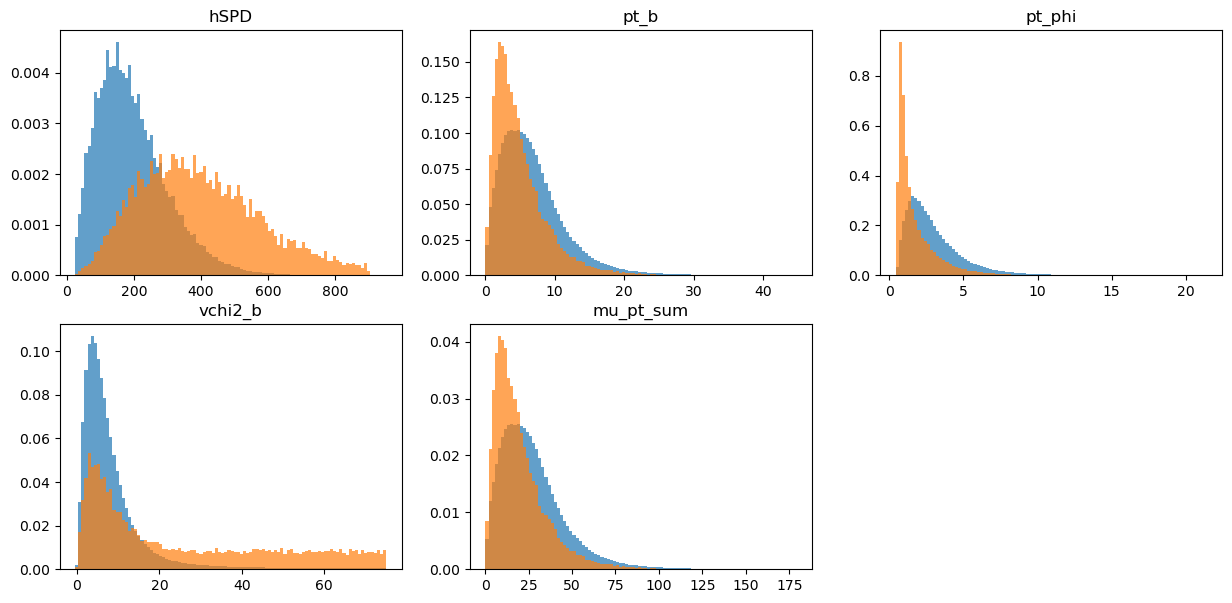

In [5]:
draw_distributions(original, target, original_weights)

In [19]:
class MultiDimensionalBinReweighter():
    def __init__(self, distributions, n_bins):
        if len(distributions) != len(n_bins):
            raise ValueError('Number of distributions and number of bins array should be equal')
        self.distributions = distributions
        self.n_bins = n_bins

        self.densities, self.edges = np.histogramdd(self.distributions, bins=self.n_bins, density=True)

    def reweight(self, new_distributions):
        if len(new_distributions) != len(self.distributions):
            raise ValueError('Number of distributions for reweighting and number of bins array should be equal')
        new_densities = np.histogramdd(new_distributions, bins=self.edges, density=True)[0]
        return np.nan_to_num(new_densities / self.densities, nan=1.0)

In [23]:
reweighter = MultiDimensionalBinReweighter([original_train[column].values for column in columns], [10, 10, 10, 10, 10])
print(reweighter.densities[0])

[[[[4.80952694e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [5.93354572e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [1.17853774e-08 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [3.96970281e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [3.20927272e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [2.42306535e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]]

  [[4.18880978e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [5.06523767e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [1.22442132e-10 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   ...
   [6.44432274e-12 0.00000000e+00 0.00000000e+00 ... 0.00